In [1]:
import pandas as pd
import numpy as np
import pathlib
import os
from random import choice, random, randint

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn.functional import one_hot
from torch.optim.lr_scheduler import StepLR, MultiStepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, hamming_loss

from pydicom import dcmread
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

# Informações do dataset treino

In [2]:
df_train = pd.read_csv('../input/unifesp-xray-bodypart-classification/train.csv')

images_dir = '../input/unifesp-xray-bodypart-classification/train/train/train'
images_list = pathlib.Path(images_dir).rglob('*.dcm')
aux = []
for path in images_list:
    path = str(path)
    pbarra = path.rfind('/')
    aux.append([path, path[pbarra+1:-6]])

df = pd.DataFrame(aux, columns=['complete_path', 'id'])

df = df.join(df_train.set_index('SOPInstanceUID'), on='id')
df.sample(5)

,complete_path,id,Target
450,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.33947601054928707279...,3
1667,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.30463613441314842264...,8
597,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.76091107552495274212...,3
876,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.10089082474655893722...,14
1658,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.88146854403303188462...,3


In [3]:
array_classes = ['Abdomen', 'Ankle', 'Cervical' 'Spine', 'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand', 'Hip', 'Knee', 'Lower' 'Leg', 'Lumbar' 'Spine', 'Others', 'Pelvis', 'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic' 'Spine', 'Wrist']
idx2classes = {k:v for k,v in enumerate(array_classes)}
classes2idx = {v:k for k,v in enumerate(array_classes)}
print (idx2classes)

{0: 'Abdomen', 1: 'Ankle', 2: 'CervicalSpine', 3: 'Chest', 4: 'Clavicles', 5: 'Elbow', 6: 'Feet', 7: 'Finger', 8: 'Forearm', 9: 'Hand', 10: 'Hip', 11: 'Knee', 12: 'LowerLeg', 13: 'LumbarSpine', 14: 'Others', 15: 'Pelvis', 16: 'Shoulder', 17: 'Sinus', 18: 'Skull', 19: 'Thigh', 20: 'ThoracicSpine', 21: 'Wrist'}


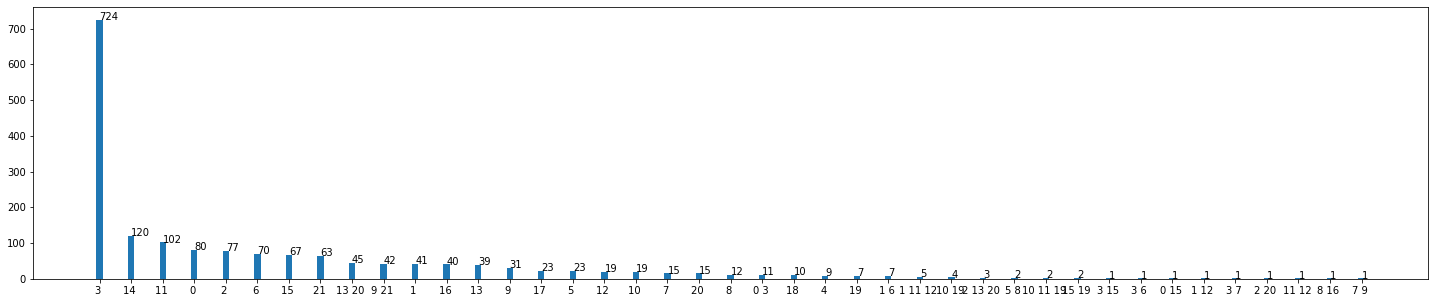

In [3]:
frequencias = df['Target'].value_counts()
plt.figure(figsize=(25, 5))
plt.bar(frequencias.index, frequencias.values, width=0.2)
plt.xticks(frequencias.index)

for k, (c,v) in enumerate(frequencias.items()):
    plt.text(c,v, str(v))

plt.show()

# Balanceamento de dataset
- Como o dataset está muito desbalanceado, será feita uma tentativa de equilibrar, retirando um pouco das instâncias da classe 3

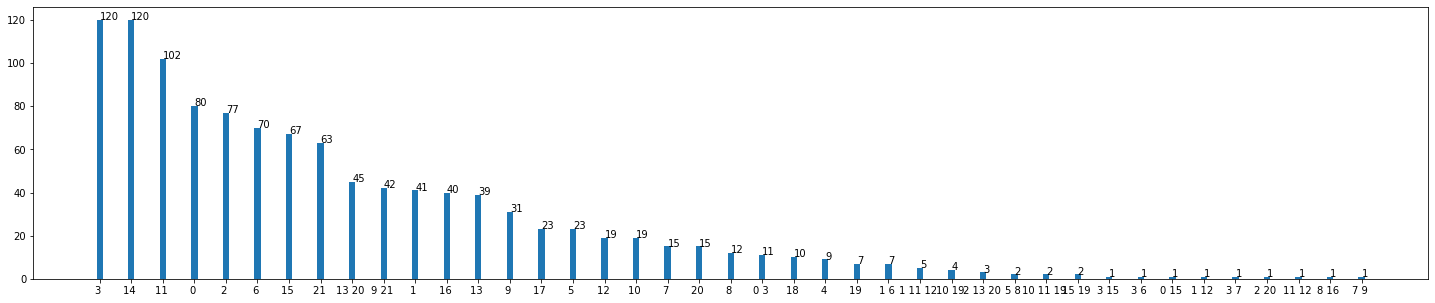

In [4]:
df_classe3 = df[df['Target'] == '3 '].sample(120)
df_sem_classe3 = df[df['Target'] != '3 ']

df = pd.concat([df_classe3, df_sem_classe3], axis=0)

frequencias = df['Target'].value_counts()
plt.figure(figsize=(25, 5))
plt.bar(frequencias.index, frequencias.values, width=0.2)
plt.xticks(frequencias.index)

for k, (c,v) in enumerate(frequencias.items()):
    plt.text(c,v, str(v))

plt.show()

# Data Augumentation
- Classes que possuem menos frequência serão rotacionadas, invertidas horizontalmente etc.. para tentar balancear ainda mais o dataset

In [15]:
os.mkdir('./images')

0 255


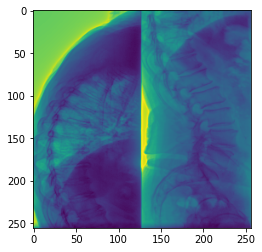

In [125]:
classes_baixa_frequencia = [classe for classe, freq in frequencias.items() if (freq <= 70)]
df_baixa_frequencia = df[df['Target'].isin(classes_baixa_frequencia)]
df_alta_frequencia = df[~df['Target'].isin(classes_baixa_frequencia)]

transformador_completo = transforms.Compose([
    transforms.Normalize(mean=0.5, std=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAutocontrast(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.RandomResizedCrop(size=(240, 240)),
    transforms.Resize((256, 256)),
    transforms.ToPILImage()
])

transformador_simples = transforms.Compose([
    transforms.Normalize(mean=0.5, std=0.5),
    transforms.Resize((256, 256)),
    transforms.ToPILImage()
])

# for complete_path, id, target in df.values:
#     img_array = dcmread(complete_path).pixel_array
img_path, _, target = choice(df.values)
img_array = dcmread(img_path).pixel_array
minimo, maximo = img_array.min(), img_array.max()
img_array = np.array(255*((img_array - minimo)/(maximo-minimo))).astype(np.uint8)
print (img_array.min(), img_array.max())
img_pil = Image.fromarray(img_array)

plt.imshow(img_pil)
plt.show()

# Criando uma classe dataset

In [6]:
train_transformer = transforms.Compose([
        transforms.Normalize(mean=0.5, std=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((256, 256))
    ])

test_transformer = transforms.Compose([
        transforms.Normalize(mean=0.5, std=0.5),
        transforms.Resize((256, 256))
    ])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=-1, std=2),
    transforms.ToPILImage()
])

class custom_dataset(Dataset):
    
    def __init__(self, df_, classes_, transformer_):
        self.df_ = df_
        self.classes_ = classes_
        self.transformer_ = transformer_
    
    def __len__(self):
        return len(self.df_)
    
    def __getitem__(self, index):
        complete_path, id, target = self.df_.values[index]
        img_array = dcmread(complete_path).pixel_array
        minimo, maximo = img_array.min(), img_array.max()
        img_array = ((img_array - minimo)/(maximo-minimo))
        
        # img_tensor = self.transformer_(torch.tensor(img_array, dtype=torch.float).unsqueeze(0)).repeat((3, 1, 1))
        img_tensor = self.transformer_(torch.tensor(img_array, dtype=torch.float).unsqueeze(0))
        
        y_tensor = torch.zeros(len(self.classes_))
        labels = [int(t) for t in str(target).split(' ') if t != '']
        y_tensor[labels] = 1
        
        return img_tensor, y_tensor

dataset = custom_dataset(df, array_classes, train_transformer)
x, y = choice(dataset)
print (x.shape, y)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
x_batch, y_batch = next(iter(dataloader))
print (f'{x_batch.shape}, {y_batch.shape}')

torch.Size([1, 256, 256]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
torch.Size([4, 1, 256, 256]), torch.Size([4, 22])


# Separação dataset
- Treino-teste para validação cruzada

In [ ]:
TEST_SIZE = 0.1
BATCH_SIZE = 8

df_train, df_test = train_test_split(df, test_size=TEST_SIZE)

train_dataset = custom_dataset(df_train, array_classes, train_transformer)
test_dataset = custom_dataset(df_test, array_classes, test_transformer)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'train_dataset: {len(train_dataset)} images')
print (f'test_dataset: {len(test_dataset)} images')
print (f'train_dataloader: {len(train_dataloader)} batches')
print (f'test_dataloader: {len(test_dataloader)} batches')

# Analisando imagens do dataloader

In [ ]:
imgs_batch, targets_batch = next(iter(dataloader))
plt.figure(figsize=(20, 5))
for k in range(4):
    plt.subplot(1, 4, k+1)
    img_pil = inv_transformer(imgs_batch[k])
    plt.imshow(img_pil)
    labels = targets_batch[k].nonzero().reshape(-1)
    labels = ', '.join([idx2classes[int(i)] for i in labels])
    plt.title(labels)

plt.show()

In [7]:
class custom_model(nn.Module):
    def __init__(self, n_classes):
        super(custom_model, self).__init__()
        self.n_classes = n_classes
        backbone = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=512, kernel_size=5, padding=0, stride=1),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=5, padding=0, stride=1),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=5, padding=0, stride=1),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 512, out_channels=512, kernel_size=5, padding=0, stride=1),
            nn.Conv2d(in_channels = 512, out_channels=256, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=5, padding=0, stride=1),
            nn.Conv2d(in_channels = 256, out_channels=256, kernel_size=3, padding=0, stride=2),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        input_test = torch.rand((1, 1, 256, 256))
        output = backbone(input_test)
        backbone_output_features = output.shape[-1]
        
        self.net = nn.Sequential(
            backbone,
            nn.Linear(in_features=backbone_output_features, out_features=4096),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(in_features=4096, out_features=2048),
            nn.LeakyReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=self.n_classes)
        )
    
    def forward(self, x):
        return self.net(x)

model = custom_model(len(array_classes))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'Device: {DEVICE}')

loss_fn = nn.BCEWithLogitsLoss()
model.to(DEVICE)
loss_fn.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = MultiStepLR(optimizer, milestones = [5, 10, 15, 20], gamma=0.5)
print ('ok')

Device: cuda:0
ok


In [ ]:
# CRIANDO UMA FUNÇÃO PARA APURAR A ACURÁCIA DO MODELO
def validar(model_, dataloader_, loss_fn_, device_):
    print ('validando...')
    model_.eval()
    with torch.no_grad():
        test_loss, total_itens = 0, 0
        ytrue, ypred = [], []
        for xbatch, ybatch in tqdm(dataloader_, ncols=70):
            xbatch, ybatch = xbatch.to(device_), ybatch.to(device_)
            output = model(xbatch)
            loss = loss_fn_(output, ybatch)
            
            test_loss += loss.item()
            total_itens += len(xbatch)

            ypred.append(output)
            ytrue.append(ybatch)

    return test_loss/total_itens #, test_accuracy

def calculate_acuracy_score(ypred_, ytrue_, softmax_fun_):
    
    ytrue = torch.vstack(ytrue_).detach().cpu()
    ypred = torch.vstack(ypred_).detach().cpu()

    ypred2 = softmax_fun_(ypred)
    max_values, max_indices = ypred2.max(-1)

    return accuracy_score(ytrue, max_indices)

def salvar_checkpoint(model_: nn.Module, epoch, train_loss_, test_loss_):
    checkpoint = {
        'state_dict': model_.state_dict(),
        'epochs': epoch,
        'train_loss': train_loss_,
        'test_loss': test_loss_
    }
    torch.save(checkpoint, f'./model_{epoch}.pth')

validar(model, test_dataloader, loss_fn, DEVICE)

# Treinamento

In [ ]:
print ('iniciando treinamento...')

cabecalho = ['epoch', 'train_loss', 'test_loss']
print ('|'.join([str(c).center(25) for c in cabecalho]))

results = []

for epoch in range(30):
    model.train()
    train_loss, total_itens = 0, 0
    
    for xbatch, ybatch in tqdm(train_dataloader, ncols=70):
        
        xbatch, ybatch = xbatch.to(DEVICE), ybatch.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(xbatch)
        loss = loss_fn(output, ybatch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        total_itens += len(xbatch)
    
    train_loss = train_loss / total_itens
    test_loss = validar(model, test_dataloader, loss_fn, DEVICE)
    scheduler.step()
    salvar_checkpoint(model, epoch, train_loss, test_loss)
    
    vetor = [epoch, train_loss, test_loss]
    results.append(vetor)
    print ('|'.join([str(round(v, 7)).center(25) for v in vetor]))

resuts = np.array(results)

In [ ]:
results = np.array(results)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(results[:,0],results[:,1])
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.plot(results[:,0],results[:,2])
plt.title('Test loss')

plt.show()

# Inferindo no dataset test

In [8]:
df_submission = pd.read_csv('../input/unifesp-xray-bodypart-classification/sample_submission.csv')

images_test_dir = '../input/unifesp-xray-bodypart-classification/test'
images_test = pathlib.Path(images_test_dir).rglob('*.dcm')

aux = []
for each_img in images_test:
    pbarra = str(each_img).rfind('/')
    img_id = str(each_img)[pbarra+1:-6]
    aux.append([str(each_img), img_id])

df_images_test = pd.DataFrame(aux, columns=['complete_path', 'SOPInstanceUID'])
df_submission = df_submission.join(df_images_test.set_index('SOPInstanceUID'), on='SOPInstanceUID')
df_submission = df_submission[['complete_path', 'SOPInstanceUID', 'Target']]
df_submission['Target'] = np.zeros(len(df_submission)).astype(int)

df_submission.sample(5)

,complete_path,SOPInstanceUID,Target
155,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.12322841378304275848...,0
200,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.13307463787746614351...,0
712,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.95064605413224761706...,0
102,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.11341118536627074881...,0
458,../input/unifesp-xray-bodypart-classification/...,1.2.826.0.1.3680043.8.498.52651123726866095901...,0


# Carregando modelo pre-treinado

In [9]:
checkpoint = torch.load('../input/custom-model/model_25.pth', map_location=torch.device('cpu'))
print (model.load_state_dict(checkpoint['state_dict']))
model.to(DEVICE)
print ('ok')

<All keys matched successfully>
ok


In [10]:
submission_dataset = custom_dataset(df_submission, array_classes, test_transformer)
submission_dataloader = DataLoader(submission_dataset, batch_size=1, shuffle=False)

ypreds = []

model.eval()
with torch.no_grad():
    for xbatch, _ in tqdm(submission_dataloader):
        xbatch = xbatch.to(DEVICE)
        ypred = model(xbatch)       
        ypreds.append(ypred)

ypreds = torch.vstack(ypreds).detach().cpu()

100%|██████████| 743/743 [00:44<00:00, 16.68it/s]


In [11]:
funcao_sigmoid = nn.Sigmoid()

ypreds_sig = funcao_sigmoid(ypreds)

targets = []
for linha in ypreds_sig:
    media, desv_p = linha.mean(), linha.std()
    linha_ordenada = sorted([[ind,float(v)] for ind,v in enumerate(linha) if (v >= media+1.5*desv_p)], key=lambda item:item[1], reverse=True)
    # esta linha ordena os índices e seus valores (sigmoidais) em ordem do maior para menor e apenas os outliers (v >= media+1.5*std)
    indices = sorted([i for i,v in linha_ordenada])[:3]
    targets.append(' '.join([str(i) for i in indices]))

df_submission['Target'] = targets

In [12]:
df_submission.drop(columns=['complete_path'], inplace=True)

In [13]:
df_submission.to_csv('submission.csv', index=False)